In [1]:
#UDACITY UD730 - assignement 2 fully connected network
#https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/udacity/2_fullyconnected.ipynb
#The goal of this assignment is to progressively train deeper and more accurate models using TensorFlow.

from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

In [2]:
pickle_file = 'notMNIST.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset = save['train_dataset']
  train_labels = save['train_labels']
  valid_dataset = save['valid_dataset']
  valid_labels = save['valid_labels']
  test_dataset = save['test_dataset']
  test_labels = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset.shape, train_labels.shape)
  print('Validation set', valid_dataset.shape, valid_labels.shape)
  print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28) (200000,)
Validation set (10000, 28, 28) (10000,)
Test set (10000, 28, 28) (10000,)


In [3]:
"""Reformat into a shape that's more adapted to the models we're going to train:
- data as a flat matrix,
- labels as float 1-hot encodings.
"""
image_size = 28
num_labels = 10

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size * image_size)).astype(np.float32)
  # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 784) (200000, 10)
Validation set (10000, 784) (10000, 10)
Test set (10000, 784) (10000, 10)


In [4]:
"""Let's load all the data into TensorFlow and build the computation graph corresponding to our training:
"""
# With gradient descent training, even this much data is prohibitive.
# Subset the training data for faster turnaround.
train_subset = 10000

graph = tf.Graph()
with graph.as_default():

  # Input data.
  # Load the training, validation and test data into constants that are
  # attached to the graph.
  tf_train_dataset = tf.constant(train_dataset[:train_subset, :])
  tf_train_labels = tf.constant(train_labels[:train_subset])
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  # These are the parameters that we are going to be training. The weight
  # matrix will be initialized using random values following a (truncated)
  # normal distribution. The biases get initialized to zero.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  # We multiply the inputs with the weight matrix, and add biases. We compute
  # the softmax and cross-entropy (it's one operation in TensorFlow, because
  # it's very common, and it can be optimized). We take the average of this
  # cross-entropy across all training examples: that's our loss.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  # We are going to find the minimum of this loss using gradient descent.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  # These are not part of training, but merely here so that we can report
  # accuracy figures as we train.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [5]:
"""Let's run this computation and iterate
"""
num_steps = 801

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
  # This is a one-time operation which ensures the parameters get initialized as
  # we described in the graph: random weights for the matrix, zeros for the
  # biases. 
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    # Run the computations. We tell .run() that we want to run the optimizer,
    # and get the loss value and the training predictions returned as numpy
    # arrays.
    _, l, predictions = session.run([optimizer, loss, train_prediction])
    if (step % 100 == 0):
      print('Loss at step %d: %f' % (step, l))
      print('Training accuracy: %.1f%%' % accuracy(
        predictions, train_labels[:train_subset, :]))
      # Calling .eval() on valid_prediction is basically like calling run(), but
      # just to get that one numpy array. Note that it recomputes all its graph
      # dependencies.
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized
Loss at step 0: 17.218233
Training accuracy: 10.9%
Validation accuracy: 14.0%
Loss at step 100: 2.230192
Training accuracy: 72.7%
Validation accuracy: 71.2%
Loss at step 200: 1.805541
Training accuracy: 75.4%
Validation accuracy: 73.4%
Loss at step 300: 1.574088
Training accuracy: 76.7%
Validation accuracy: 74.1%
Loss at step 400: 1.417489
Training accuracy: 77.3%
Validation accuracy: 74.4%
Loss at step 500: 1.301370
Training accuracy: 78.1%
Validation accuracy: 74.6%
Loss at step 600: 1.210453
Training accuracy: 78.6%
Validation accuracy: 74.8%
Loss at step 700: 1.136684
Training accuracy: 79.0%
Validation accuracy: 75.0%
Loss at step 800: 1.075145
Training accuracy: 79.4%
Validation accuracy: 75.0%
Test accuracy: 82.7%


In [6]:
"""Let's now switch to stochastic gradient descent training instead, which is much faster.
The graph will be similar, except that instead of holding all the training data into a constant node, 
we create a Placeholder node which will be fed actual data at every call of session.run().
"""
batch_size = 128

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,
                                    shape=(batch_size, image_size * image_size))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables.
  weights = tf.Variable(
    tf.truncated_normal([image_size * image_size, num_labels]))
  biases = tf.Variable(tf.zeros([num_labels]))
  
  # Training computation.
  logits = tf.matmul(tf_train_dataset, weights) + biases
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(
    tf.matmul(tf_valid_dataset, weights) + biases)
  test_prediction = tf.nn.softmax(tf.matmul(tf_test_dataset, weights) + biases)

In [7]:
num_steps = 3001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print("Initialized")
  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 500 == 0):
      print("Minibatch loss at step %d: %f" % (step, l))
      print("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print("Validation accuracy: %.1f%%" % accuracy(
        valid_prediction.eval(), valid_labels))
  print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch loss at step 0: 18.161428
Minibatch accuracy: 11.7%
Validation accuracy: 12.4%
Minibatch loss at step 500: 1.871672
Minibatch accuracy: 76.6%
Validation accuracy: 75.1%
Minibatch loss at step 1000: 0.931497
Minibatch accuracy: 82.8%
Validation accuracy: 76.7%
Minibatch loss at step 1500: 1.180908
Minibatch accuracy: 78.9%
Validation accuracy: 76.6%
Minibatch loss at step 2000: 1.182772
Minibatch accuracy: 71.9%
Validation accuracy: 78.0%
Minibatch loss at step 2500: 0.848845
Minibatch accuracy: 78.9%
Validation accuracy: 78.2%
Minibatch loss at step 3000: 1.028661
Minibatch accuracy: 71.9%
Validation accuracy: 78.4%
Test accuracy: 85.8%


In [8]:
"""Problem
Turn the logistic regression example with SGD into a 1-hidden layer neural network with rectified linear units nn.relu() 
and 1024 hidden nodes. This model should improve your validation / test accuracy.

batch size = 128
learning rate = 0.5   | num steps = 3001  | test accuracy = 88,5%
learning rate = 0.05  | num steps = 3001  | test accuracy = 88,6%
learning rate = 0.05  | num steps = 30001 | test accuracy = 91,7%
learning rate = 0.005 | num steps = 30001 | test accuracy = 89,7%
learning rate = 0.005 | num steps = 60001 | test accuracy = 90,7%

batch size = 256 | learning rate = 0.05   | num steps = 30001 | test accuracy = 91,6%
batch size = 512 | learning rate = 0.05   | num steps = 30001 | test accuracy = 91,7%
batch size = 512 | learning rate = 0.005  | num steps = 30001 | test accuracy = 86,6%
batch size = 512 | learning rate = 0.005  | num steps = 60001 | test accuracy = 90,4%

Intuitively, how does mini-batch size affect the performance of (stochastic) gradient descent? 
https://www.quora.com/Intuitively-how-does-mini-batch-size-affect-the-performance-of-stochastic-gradient-descent
"""

# Parameters
learning_rate = 0.05
num_steps = 30001 #training cycle | training_epochs
batch_size = 512
#display_step = 1

# Network Parameters
n_hidden_1 = 1024 # 1st layer number of features
n_input = image_size * image_size # data input (img shape: 28*28)
#num_labels = 10 #(0-9)

def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def oneHiddenLayerModel (x, weights, biases):
  # Hidden layer with RELU activation
  hiddenLayer = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
  hiddenLayer = tf.nn.relu(hiddenLayer)
  # Output layer with linear activation
  outputLayer = tf.add(tf.matmul(hiddenLayer, weights['out']), biases['out'])
  return outputLayer

graph = tf.Graph()
with graph.as_default():

  # Input data. For the training data, we use a placeholder that will be fed
  # at run time with a training minibatch.
  tf_train_dataset = tf.placeholder(tf.float32,shape=(batch_size, n_input))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  
  # Variables : layers weight & bias
  weights = {
    'h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1])),
    'out': tf.Variable(tf.truncated_normal([n_hidden_1, num_labels]))
  }
  biases = {
    'b1': tf.Variable(tf.zeros([n_hidden_1])),
    'out': tf.Variable(tf.zeros([num_labels]))
  }
 
  # Construct model
  pred = oneHiddenLayerModel(tf_train_dataset, weights, biases)

  # Loss (Cost)
  loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=tf_train_labels))
  
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(pred)
  valid_prediction = tf.nn.softmax(oneHiddenLayerModel(tf_valid_dataset, weights, biases))
  test_prediction = tf.nn.softmax(oneHiddenLayerModel(tf_test_dataset, weights, biases))




In [9]:

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print ('Initialized')
  summary_data = np.zeros((num_steps, 3))

  for step in range(num_steps):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    # Generate a minibatch.
    batch_data = train_dataset[offset:(offset + batch_size), :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)

    valid_accuracy = accuracy(valid_prediction.eval(), valid_labels)
    summary_data[step] = [step, valid_accuracy, l]
    
    if (step % 5000 == 0):
      print ("Minibatch loss at step", step, ":", l)
      print ("Minibatch accuracy: %.1f%%" % accuracy(predictions, batch_labels))
      print ("Validation accuracy: %.1f%%" % valid_accuracy)
  print ("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))



Initialized
Minibatch loss at step 0 : 312.905
Minibatch accuracy: 6.4%
Validation accuracy: 17.4%
Minibatch loss at step 5000 : 4.41653
Minibatch accuracy: 87.9%
Validation accuracy: 82.9%
Minibatch loss at step 10000 : 2.54081
Minibatch accuracy: 86.9%
Validation accuracy: 83.7%
Minibatch loss at step 15000 : 1.94139
Minibatch accuracy: 86.9%
Validation accuracy: 83.8%
Minibatch loss at step 20000 : 1.79119
Minibatch accuracy: 86.9%
Validation accuracy: 85.2%
Minibatch loss at step 25000 : 2.60367
Minibatch accuracy: 85.4%
Validation accuracy: 84.7%
Minibatch loss at step 30000 : 0.860302
Minibatch accuracy: 87.3%
Validation accuracy: 84.3%
Test accuracy: 91.5%


30001


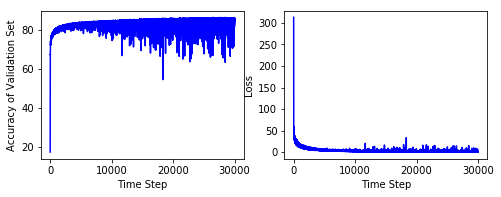

In [10]:
#to go further, plot accuracies (train & validation) and loss through epochs regarding range of parameters
import matplotlib.pyplot as plt
%matplotlib inline

print (summary_data.shape[0])
    
    
fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(221)
ax1.plot(summary_data[:,0], summary_data[:,1], 'b-')
ax1.set_xlabel("Time Step")
ax1.set_ylabel("Accuracy of Validation Set")
ax2 = fig.add_subplot(222)
ax2.plot(summary_data[:,0], summary_data[:,2], 'b-')
ax2.set_xlabel("Time Step")
ax2.set_ylabel("Loss")